# **Анализ данных национального виктимизационного опроса**

# Данный проект посвящен изучению преступности на территории Российской Федерации. Целью работы является выявление связей между разными характеристиками преступлений.
>##### Данные для анализа собраны Институтом проблем правоприменения (ИПП) при ЕУ СПб и представляют результаты телефонного опроса респондентов не моложе 18 лет на основании простой случайной выборки телефонных номеров. Респонденты опрашивались не зависимо от гражданства, но, по понятным причинам, большинство (98.1%) были гражданами РФ. Вопросы делились на анкетные (пол, возраст, социо-демографический профиль), основной («были ли жертвой преступления») и уточняющие вопросы о преступлениях (где, когда и т.п.). Анкета составлена специальным образом профессионалами, учитывая многие особенности, например специфику русского языка.
# Задачи данного исследования:
*   Ознакомиться с форматом данных, осуществить предобработку.
*   Сделать анализ данных опроса жителей РФ о преступлениях, жертвами которых они становились.
*   Cделать визуализации найденных закономерностей.





##Структура проекта

---


1.   [***Импорт необходимых библиотек***](#Импорт-необходимых-библиотек)
2.   [***Загрузка и предварительная обработка данных***](#Загрузка-и-предварительная-обработка-данных)
3.   [***Был ли респодент жертвой преступления?***](#Был-ли-респодент-жертвой-преступления?)
4.   [***Анализ влияния полового признака на совершение преступлений и подверженность им***](#Анализ-влияния-полового-признака-на-совершение-преступлений-и-подверженность-им)
5.   [***Был ли найден нападавший?***](#Был-ли-найден-нападавший?)
6.   [***Была ли необходима медицинская помощь?***](#Была-ли-необходима-медицинская-помощь?)
7.   [***Был ли нападавший при исполнении?***](#Был-ли-нападавший-при-исполнении?)
8.   [***Анализ частоты видов преступлений***](#Анализ-частоты-видов-преступлений)
9.   [***Анализ влияния возраста на подверженность преступлениям***](#Анализ-влияния-возраста-на-подверженность-преступлениям)
10.   [***Анализ влияния дохода на подверженность преступлениям***](#Анализ-влияния-дохода-на-подверженность-преступлениям)
11.   [***Анализ скорости реагирования правоохранителей***](#Анализ-скорости-реагирования-правоохранителей)
12.   [***Анализ материального ущерба пострадавших***](#Анализ-материального-ущерба-пострадавших)
13.   [***Анализ зависимости вида преступлений от времени суток***](#Анализ-зависимости-вида-преступлений-от-времени-суток)


---





## Импорт необходимых библиотек

In [200]:
#Импорт

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tensorflow.keras.utils import get_file as getfile  # Используется для того, чтобы скачать датасет напрямую
import matplotlib.patches as mpatches
from scipy import stats
from copy import copy

## Загрузка и предварительная обработка данных

*После изучения данных и рекомендаций в технической документации, было принято решение использовать **только сконструированные переменные**, которые не несут в себе субъективных оценок респондента и являются необходимыми для анализа, добавив к ним переменные:*


*   crime_asked_medical_help – нуждалась ли жертва в оказании медицинской помощи (логическая переменная)

*   offender_is_on_duty – был ли преступник должностным лицом или при исполнении (логическая переменная)





**Загрузка файла с серверов Гарварда**

In [201]:
# Загрузка файла с серверов Гарварда
dataset_path = getfile("dataset.csv", "https://dataverse.harvard.edu/api/access/datafile/3676762?format=original&gbrecs=true")

In [202]:
# Преобразование в датафрейм
raw_dataset = pd.read_csv(dataset_path)
df = raw_dataset.copy()

# Добавляем переменные
df['crime_asked_medical_help'] = df['Q28']
df['offender_is_on_duty'] = df['Q12']
df['interview_duration'] = df['IVDur']
df.drop(df.iloc[:, :122], inplace=True, axis=1)


# Список удаляемых сконструированных переменных, несущих в себе субъективные оценки корреспондента / не используемых в анализе
drop_list = ['resp_place_is_city', 'resp_place_population',
         'resp_household_size', 'resp_is_enforcers_familiar',
         'resp_sample_group', 'resp_ses_is_pensioner', 
         'resp_ses_is_welfare', 'resp_ses_is_looked_for_job', 
         'resp_ses_job_is_manager', 'resp_ses_job_is_freelancer', 
         'resp_ses_job_is_manual', 'resp_ses_job_is_private', 
         'resp_ses_job_is_public', 'resp_ses_is_student', 
         'resp_ses_is_employed', 'crime_is_offender_seen', 
         'crime_place', 'crime_place_remote', 'crime_place_is_home', 
         'crime_is_people_around','victim_is_self_accuse', 
         'victim_damage_rub_ln', 'victim_is_repeat_contact_with_police', 
         'victim_police_number_of_contacts', 'victim_who_contacted_police',
         'victim_way_to_contact_police', 'victim_is_compensated', 
         'victim_is_reconciliation', 'victim_is_told_anyone', 
         'offender_is_alone','offender_is_familiar', 
         'offender_relationship'] 

df.drop(drop_list, axis=1, inplace=True) # Удаление переменных

# Расставляем столбцы в правильном порядке
cols =['interview_duration', 'resp_is_male', 'resp_age',
       'resp_is_living_alone', 'resp_is_married',
       'resp_income', 'resp_edu', 'resp_is_crime_record',
       'resp_is_russian_citizen', 'resp_is_crime_victim', 'resp_ses',
       'crime_season', 'crime_is_remote', 'crime_is_property_damage',
       'crime_is_violent_damage', 'crime_is_seeking_medical_help',
       'crime_asked_medical_help', 'crime_is_property_acquisition',
       'crime_is_fraud', 'crime_is_threat', 'crime_type',
       'crime_place_grouped', 'crime_is_daytime', 'victim_is_reporting',
       'victim_damage_physical', 'victim_damage_rub',
       'victim_is_crime_case_initiated', 'victim_police_reaction_time',
       'victim_is_offender_found', 'victim_who_found_offender',
       'victim_is_offender_punished', 'victim_is_went_to_court',
       'victim_compensation', 'offender_is_male', 'offender_is_on_duty',
       'offender_is_drug_intoxicated', 'offender_relationship_grouped']

df = df[cols]

df.head()

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,resp_ses,crime_season,crime_is_remote,crime_is_property_damage,crime_is_violent_damage,crime_is_seeking_medical_help,crime_asked_medical_help,crime_is_property_acquisition,crime_is_fraud,crime_is_threat,crime_type,crime_place_grouped,crime_is_daytime,victim_is_reporting,victim_damage_physical,victim_damage_rub,victim_is_crime_case_initiated,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
0,544,0,57,0.0,0.0,3.0,3.0,0.0,1.0,1,2.0,3.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,6.0,7.0,1.0,0.0,NaN,300.0,NaN,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,1643,0,59,0.0,1.0,NaN,3.0,0.0,1.0,1,2.0,1.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,3.0,2.0,1.0,1.0,NaN,80000.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,NaN,0.0,6.0
2,676,0,35,0.0,1.0,NaN,3.0,0.0,1.0,1,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,6.0,7.0,1.0,1.0,NaN,3000.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,510,0,22,1.0,0.0,3.0,3.0,0.0,1.0,1,3.0,3.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,5.0,1.0,1.0,1.0,NaN,7000.0,0.0,1.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,1107,0,79,0.0,1.0,1.0,3.0,0.0,1.0,1,2.0,3.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,8.0,7.0,1.0,1.0,NaN,0.0,1.0,2.0,0.0,NaN,NaN,0.0,4.0,1.0,NaN,0.0,6.0


Создадим переменную, содержащию список цветов, для последующего использования при построении графиков в едином стиле

In [272]:
colors = ['powderblue',
          'steelblue',
          'deepskyblue',
          'lightblue',
          'darkturquoise',
          'cadetblue',
          'teal']

pltclr = 'silver'
digclr = 'whitesmoke'

Проведен настройку библиотеки ***Pandas***, в частности отключим предупреждение о копировании данных

In [204]:
pd.options.mode.chained_assignment = None  # default='warn'

## Был ли респодент жертвой преступления?


Определим процентное отношение людей, которые являлись жертвами преступлений среди опрошенных.

Создадим функцию для замены номера категории на её название

In [205]:
def ifvictim(x):
  if x:
    return "Постарадал"
  else:
    return "Не пострадал"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [206]:
resp_is_victim = df['resp_is_crime_victim'].dropna() \
                        .apply(ifvictim)

print("Выборка содержит", len(resp_is_victim), "строк")

Выборка содержит 16818 строк


Посчитаем процентное содержание каждой категории в выборке

In [207]:
resp_is_victim_count = resp_is_victim.value_counts(1).sort_values()

print("Пострадал ли респондент от преступления?:")
for i in range(len(resp_is_victim_count)):
  print("{} - {:.3f}%".format(resp_is_victim_count.index[i],
                              resp_is_victim_count[i] * 100))

Пострадал ли респондент от преступления?:
Постарадал - 17.844%
Не пострадал - 82.156%


Построим по полученным значениям диаграмму

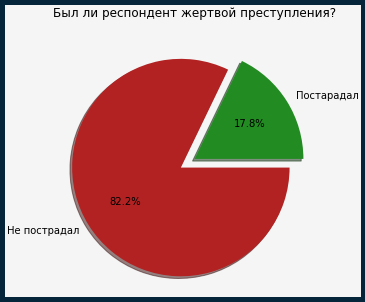

In [274]:
# Красивые графики
plt.figure(figsize=(10, 5), linewidth=10, edgecolor="#04253a").set_facecolor(digclr)
plt.pie(resp_is_victim_count.tolist(), labels=resp_is_victim_count.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.title("Был ли респондент жертвой преступления?")
plt.show()

**Вывод:**
> Почти каждый четвертый респондент является жертвой преступления

Теперь разделим данные на две выборки - **"*Пострадавшие*"** и **"*Не пострадавшие*"**

In [209]:
victims = df[df['resp_is_crime_victim'] == 1]

not_victims = df[df['resp_is_crime_victim'] == 0]

In [210]:
victims.head(5)

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,resp_ses,crime_season,crime_is_remote,crime_is_property_damage,crime_is_violent_damage,crime_is_seeking_medical_help,crime_asked_medical_help,crime_is_property_acquisition,crime_is_fraud,crime_is_threat,crime_type,crime_place_grouped,crime_is_daytime,victim_is_reporting,victim_damage_physical,victim_damage_rub,victim_is_crime_case_initiated,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
0,544,0,57,0.0,0.0,3.0,3.0,0.0,1.0,1,2.0,3.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,6.0,7.0,1.0,0.0,NaN,300.0,NaN,NaN,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
1,1643,0,59,0.0,1.0,NaN,3.0,0.0,1.0,1,2.0,1.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,0.0,3.0,2.0,1.0,1.0,NaN,80000.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,NaN,0.0,6.0
2,676,0,35,0.0,1.0,NaN,3.0,0.0,1.0,1,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,6.0,7.0,1.0,1.0,NaN,3000.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,510,0,22,1.0,0.0,3.0,3.0,0.0,1.0,1,3.0,3.0,0.0,1.0,0.0,0.0,NaN,1.0,1.0,0.0,5.0,1.0,1.0,1.0,NaN,7000.0,0.0,1.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,1107,0,79,0.0,1.0,1.0,3.0,0.0,1.0,1,2.0,3.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,8.0,7.0,1.0,1.0,NaN,0.0,1.0,2.0,0.0,NaN,NaN,0.0,4.0,1.0,NaN,0.0,6.0


In [211]:
not_victims.head(5)

,interview_duration,resp_is_male,resp_age,resp_is_living_alone,resp_is_married,resp_income,resp_edu,resp_is_crime_record,resp_is_russian_citizen,resp_is_crime_victim,resp_ses,crime_season,crime_is_remote,crime_is_property_damage,crime_is_violent_damage,crime_is_seeking_medical_help,crime_asked_medical_help,crime_is_property_acquisition,crime_is_fraud,crime_is_threat,crime_type,crime_place_grouped,crime_is_daytime,victim_is_reporting,victim_damage_physical,victim_damage_rub,victim_is_crime_case_initiated,victim_police_reaction_time,victim_is_offender_found,victim_who_found_offender,victim_is_offender_punished,victim_is_went_to_court,victim_compensation,offender_is_male,offender_is_on_duty,offender_is_drug_intoxicated,offender_relationship_grouped
100,247,1,32,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,91,1,38,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,259,0,30,0.0,1.0,3.0,3.0,0.0,1.0,0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,105,0,56,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,245,1,19,1.0,0.0,5.0,1.0,0.0,0.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Анализ влияния полового признака на совершение преступлений и подверженность им

Определим влияние полового признака на участие в криминальной сфере. Для этого найдем процентное содержание мужчин и женщин средих пострадавших и нападавших.

Создадим функцию для замены номера категории на её название

In [212]:
def ifmale(x):
  if x:
    return "Мужчина"
  else:
    return "Женщина"

Создадим необходимые выборки из датафрейма и определим, достаточны ли их размеры для последующего анализа

In [213]:
ifmale_offender = victims['offender_is_male'].dropna().apply(ifmale)
ifmale_resp = victims['resp_is_male'].dropna().apply(ifmale)

print("Выборка содержит", len(ifmale_offender), "строк")
print("Выборка содержит", len(ifmale_resp), "строк")

Выборка содержит 1467 строк
Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборках

In [214]:

offender_count = ifmale_offender.value_counts(1)

print("Среди нападавших:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(offender_count.index[i],
                              offender_count[i] * 100))

victim_count = ifmale_resp.value_counts(1)

print("\nСреди пострадавших:")
for i in range(len(offender_count)):
  print("{} - {:.3f}%".format(victim_count.index[i],
                              victim_count[i] * 100))

Среди нападавших:
Мужчина - 78.391%
Женщина - 21.609%

Среди пострадавших:
Женщина - 53.915%
Мужчина - 46.085%


Затем построим по получившимся значениям график.

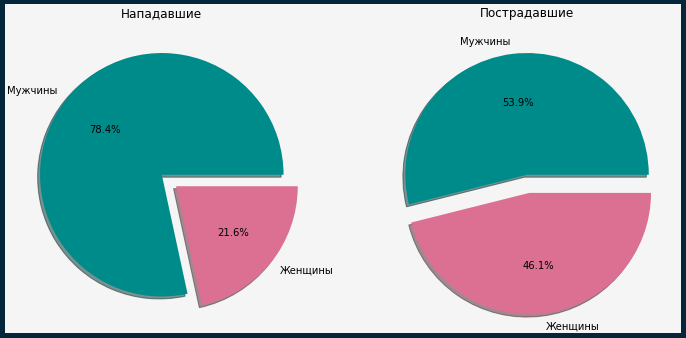

In [275]:
plt.figure(figsize=(12, 8), linewidth=10, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 2, 1)
ax.set_title("Нападавшие")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')
ax.pie(offender_count,
       labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
       explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 2, 2)
ax.set_title("Пострадавшие")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(victim_count,  labels=["Мужчины", "Женщины"],
       colors=('darkcyan', 'palevioletred'),
      explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

plt.show()

**Вывод:**
> Мужчины чаще замешаны в преступлениях (в качестве жертвы или правонарушителя)

> Процент мужчин среди преступников значительно выше процента женщин

> Среди пострадавших процент мужчин и женщин отличается незначительно



## Был ли найден нападавший?

Определим процентное отношение случаев, в которых был найден нападавший.

Создадим функцию для замены номера категории на её название

In [216]:
def off_found_group(x):
  if x == 1.0: return "Нападавший найден"
  else: return "Нападавший не найден"

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [217]:
offender_found = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group)

print("Выборка содержит", len(offender_found), "строк")

Выборка содержит 3001 строк


In [218]:
offender_found_count = victims['victim_is_offender_found'].dropna() \
.apply(off_found_group).value_counts(1)

print("Был ли найден нападавший?:")
for i in range(len(offender_found_count)):
  print("{:<20} - {:.3f}%".format(offender_found_count.index[i],
                              offender_found_count[i] * 100))

Был ли найден нападавший?:
Нападавший не найден - 73.775%
Нападавший найден    - 26.225%


Построим по полученным значениям график.

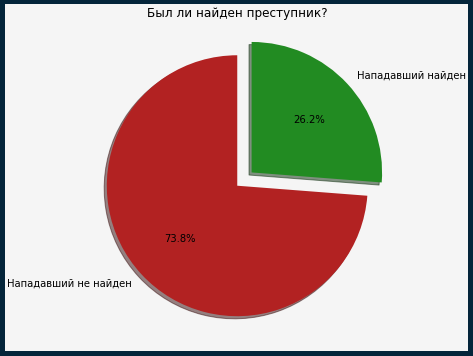

In [276]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=10, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(offender_found_count.tolist(), labels=offender_found_count.index,
        colors=('firebrick', 'forestgreen'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Был ли найден преступник?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> По данным опроса, в трёх из четырёх случаев преступления правонарушитель остаётся не найденным

## Была ли необходима медицинская помощь?

Определим процентное отношение пострадавших от физического насилия, которым нужна была медицинская помощь.

Создадим функцию для замены номера категории на её название

In [220]:
def is_seeking_medical_help(x):
   if x == 1.0:
     return 'Нуждался в помощи'
   else:
     return 'Не нуждался в помощи'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [221]:
med_help = victims['crime_is_seeking_medical_help'] \
                [victims['crime_is_violent_damage'] == 1.0] \
              .apply(is_seeking_medical_help)

print("Выборка содержит", len(med_help), "строк")

Выборка содержит 350 строк


Посчитаем процентное содержание каждой категории в выборке

In [222]:
med_help_perc = med_help.value_counts(1).sort_values()

print("Была ли необходима мед. помощь?:")
for i in range(len(med_help_perc)):
  print("{:<20} - {:.3f}%".format(med_help_perc.index[i],
                                  med_help_perc[i] * 100))

Была ли необходима мед. помощь?:
Нуждался в помощи    - 48.286%
Не нуждался в помощи - 51.714%


Построим по полученным значениям график.

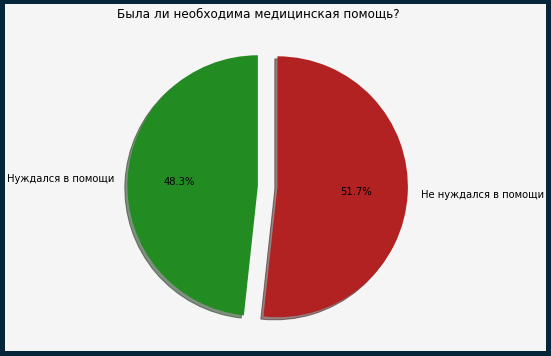

In [277]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=10, edgecolor="#04253a") \
.set_facecolor(digclr)

plt.pie(med_help_perc, labels=med_help_perc.index,
        colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Была ли необходима медицинская помощь?')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Только в половине случаев физического насилия пострадавший нуждался в медицинской помощи

## Был ли нападавший при исполнении?

Определим случаи, в которых нападавших был при исполнении. Также определим вид занятости, если преступник был при исполнении.

Создадим функцию для замены номера категории на её название

In [224]:
def offender_group(x):
  d = {1.0: 'Правоприменитель',
       2.0: 'Представитель власти', 
       3.0: 'Военный', 
       4.0: 'Сотрудник коммерческой организации', 
       5.0: 'Не при исполнении'}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [225]:
offender_on_duty = victims['offender_is_on_duty'] \
[victims['offender_is_on_duty'] != 6.0].dropna().apply(offender_group)

print("Выборка содержит", len(offender_on_duty), "строк")

Выборка содержит 1215 строк


Посчитаем процентное содержание каждой категории в выборке

In [226]:
offender_on_duty_group = offender_on_duty.value_counts(1).sort_values() # Процентное отношение всех должностных лиц-преступников

print("Был ли нападавший при исполнении?:")
for i in range(len(offender_on_duty_group)):
  print("{:<35} - {:.3f}%".format(offender_on_duty_group.index[i],
                                  offender_on_duty_group[i] * 100))
  

Был ли нападавший при исполнении?:
Военный                             - 0.658%
Представитель власти                - 2.551%
Правоприменитель                    - 3.951%
Сотрудник коммерческой организации  - 15.391%
Не при исполнении                   - 77.449%


Создадим две переменные, в первую поместим процентное соотношение видов занятости среди нападавших при исполнении, во вторую процентное соотношение нападавших при исполнении к нападавшим не при исполнении.

In [227]:
offender_if_on_duty = copy(offender_on_duty_group[:4])
s = sum(offender_if_on_duty)

for i in range(len(offender_if_on_duty)):
  offender_if_on_duty[i] = offender_if_on_duty[i] / s

sum_on_duty = [sum(offender_on_duty_group[:4]), offender_on_duty_group[4]]

print("При исполнении    - {:.3f}%\nНе при исполнении - {:.3f}%" \
      .format(sum_on_duty[0] * 100, sum_on_duty[1] * 100))

При исполнении    - 22.551%
Не при исполнении - 77.449%


Построим по полученным значениям график.

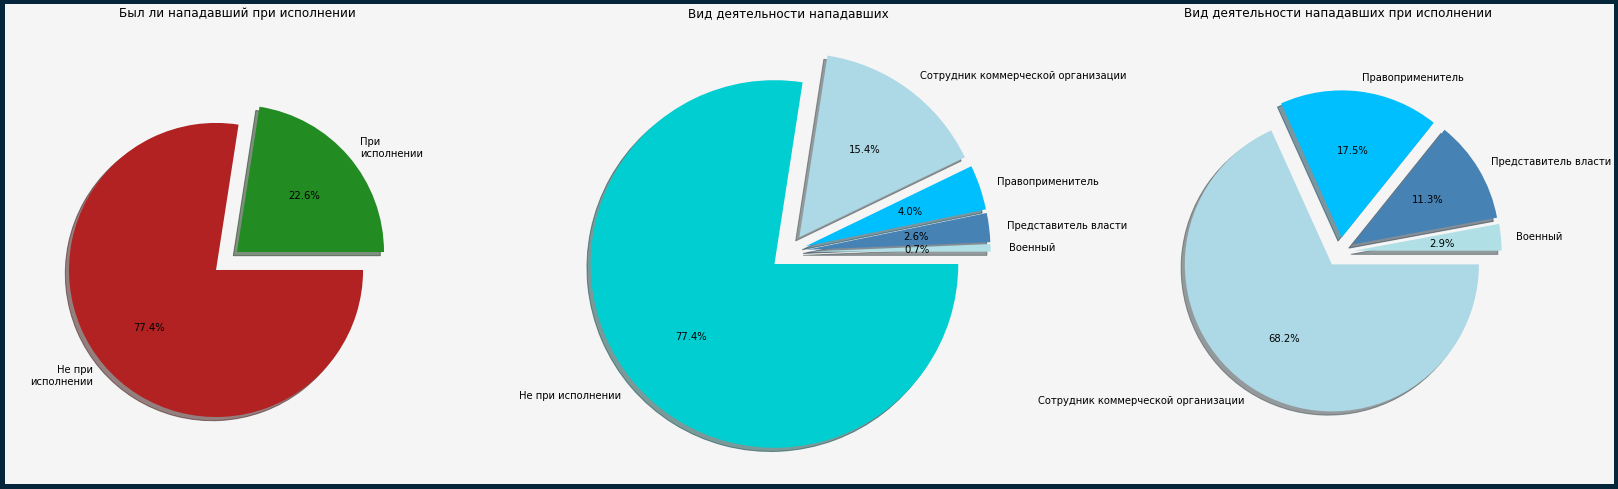

In [299]:
# Красивые графики
plt.figure(figsize=(28, 10), linewidth=10, edgecolor="#04253a") \
.set_facecolor(digclr)

ax = plt.subplot(1, 3, 1)
ax.set_title("Был ли нападавший при исполнении")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')
ax.pie(sum_on_duty,
       labels=["При\nисполнении", "Не при\nисполнении"], radius=0.8,
       colors=('forestgreen', 'firebrick'), explode=(0, 0.15),
        shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 3, 2)
ax.set_title("Вид деятельности нападавших")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(offender_on_duty_group, labels=offender_on_duty_group.index,
       radius=1, colors=colors,
       explode=(0.1, 0.1, 0.1, 0.1, 0.1),
       shadow=True, autopct='%1.1f%%')

ax = plt.subplot(1, 3, 3)
ax.set_title("Вид деятельности нападавших при исполнении ")
ax.grid(which='major', color = 'gray', axis='y', linestyle=':')

ax.pie(offender_if_on_duty, labels=offender_if_on_duty.index,
       radius=0.8, colors=colors,
       explode=(0.08, 0.08, 0.08, 0.08),
       shadow=True, autopct='%1.1f%%')



plt.show()

**Вывод:**
> Более 20% злоумышленников находились при исполнении своих обязанностей

> Чуть больше 7% от них являлись представителями силовых структур 

## Анализ частоты видов преступлений

Определим процентное отношение частоты каждого преступления.

Создадим функцию для замены номера категории на её название

In [229]:
def crime_type_rename(x):
  dic = {1.0: 'Нападение', 
         2.0: 'Угрозы ', 
         3.0: 'Грабеж и разбой ', 
         4.0: 'Кража', 
         5.0: 'Мошенничество', 
         6.0: 'Мошенничество', 
         7.0: 'Прочее'}
  return dic[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [230]:
crime_type = victims['crime_type'].drop(
    victims['crime_type'][victims['crime_type'] == 8.0].index) \
    .apply(crime_type_rename)

print("Выборка содержит", len(crime_type), "строк")

Выборка содержит 2422 строк


Посчитаем процентное содержание каждой категории в выборке

In [231]:
crime_type_perc = crime_type.value_counts(1)

print("Вид преступления:")
for i in range(len(crime_type_perc)):
  print("{:<16} - {:.3f}%".format(crime_type_perc.index[i],
                                  crime_type_perc[i] * 100))


Вид преступления:
Мошенничество    - 40.173%
Кража            - 25.021%
Грабеж и разбой  - 12.428%
Угрозы           - 8.629%
Нападение        - 8.051%
Прочее           - 5.698%


Построим по полученным значениям график

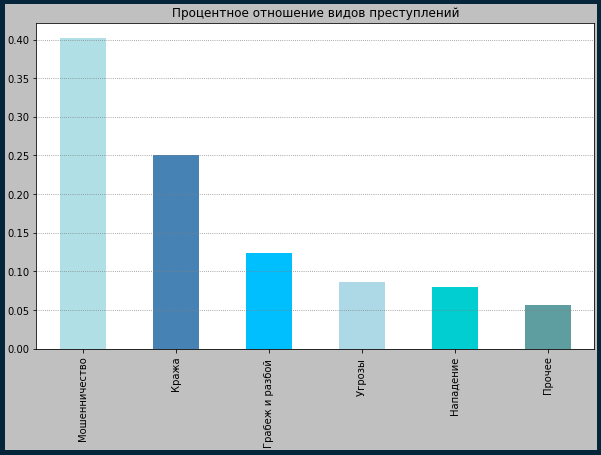

In [282]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=10, edgecolor="#04253a") \
.set_facecolor(pltclr)

crime_type_perc.plot.bar(color=colors)
plt.title('Процентное отношение видов преступлений')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наиболее частый вид преступления по данным опроса – мошенничество (почти половина от всех преступлений)

## Анализ влияния возраста на подверженность преступлениям

Определим влияния возраста человека на подверженность преступлению. 

Создадим функцию для замены номера категории на её название

In [233]:
def age_group(x):
  if 18 <= x <= 24:
    return '18-24'
  elif 25 <= x <= 34:
    return '25-34'
  elif 35 <= x <= 44:
    return '35-44'
  elif 45 <= x <= 54:
    return '45-54'
  elif 55 <= x <= 64:
    return '55-64'
  elif x >= 65:
    return '65+'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [234]:
resp_age = victims['resp_age'].apply(age_group)

print("Выборка содержит", len(resp_age), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [235]:
group_resp_age = resp_age.value_counts(1).sort_index()

print("Среди пострадавших:")
for i in range(len(group_resp_age)):
  print("{:^5} лет - {:.3f}%".format(group_resp_age.index[i],
                                  group_resp_age[i] * 100))

Среди пострадавших:
18-24 лет - 11.096%
25-34 лет - 28.391%
35-44 лет - 21.593%
45-54 лет - 15.095%
55-64 лет - 13.462%
 65+  лет - 10.363%


Построим по полученным значениям график.

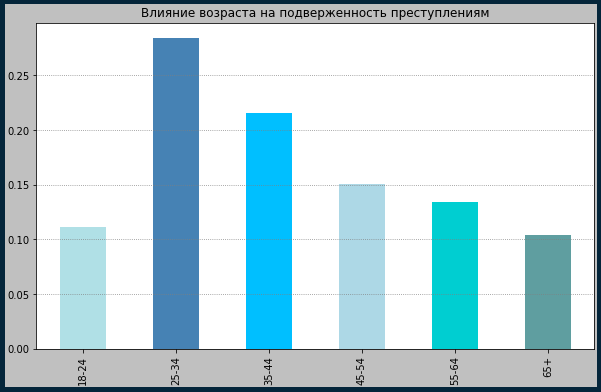

In [284]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=10, edgecolor="#04253a") \
.set_facecolor(pltclr)
group_resp_age.plot.bar(color=colors)

plt.title('Влияние возраста на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Наиболее подвержены преступлениям лица 25-34 лет, далее процент жертв уменьшается

Теперь попробуем найти зависимость типа преступления от возраста. Для этого создадим выборки по каждой возрастной категории и посчитаем процент каждого вида преступлений среди полученных выборок

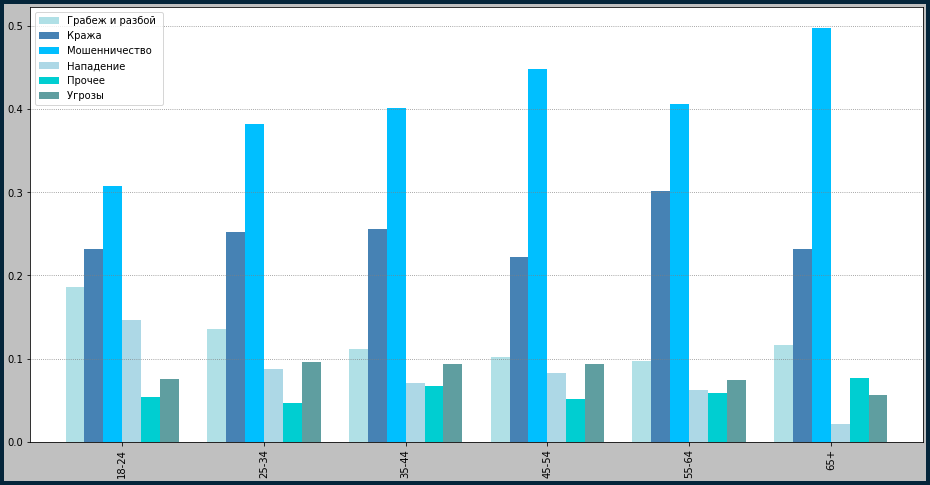

In [286]:
victims['resp_age_group'] = victims['resp_age'].apply(age_group)

crime_age = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_age_group']], axis=1).dropna()

s = [crime_age['crime_type'][crime_age['resp_age_group'] == '18-24'].apply(crime_type_rename).value_counts(1).sort_index(),
     crime_age['crime_type'][crime_age['resp_age_group'] == '25-34'].apply(crime_type_rename).value_counts(1).sort_index(),
     crime_age['crime_type'][crime_age['resp_age_group'] == '35-44'].apply(crime_type_rename).value_counts(1).sort_index(),
     crime_age['crime_type'][crime_age['resp_age_group'] == '45-54'].apply(crime_type_rename).value_counts(1).sort_index(),
     crime_age['crime_type'][crime_age['resp_age_group'] == '55-64'].apply(crime_type_rename).value_counts(1).sort_index(),
     crime_age['crime_type'][crime_age['resp_age_group'] == '65+'].apply(crime_type_rename).value_counts(1).sort_index()]

fp = pd.DataFrame(s, index=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], columns=s[0].index)

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.set_facecolor('white')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
fig.set_facecolor(pltclr)

fp.plot.bar(color=colors, ax=ax, width=0.8)

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.show()


**Вывод:**


> Пожилые люди чаще других становятся жертвами мошенников

> Молодые люди чаще остальных становятся жертвами грабежей и нападений





## Анализ влияния дохода на подверженность преступлениям

Для начала найдем процентное отношение каждого вида дохода среди пострадавших.

Создадим функцию для замены номера категории на её название

In [238]:
def income(x):
  d = {1.0: "Бедность",
       2.0: "Низкий",
       3.0: "Средний",
       4.0: "Высокий",
       5.0: "Очень высокий"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [239]:
resp_income = victims['resp_income'].dropna() \
                    .sort_values().apply(income)

print("Выборка содержит", len(resp_income), "строк")

Выборка содержит 2910 строк


Посчитаем процентное содержание каждой категории в выборке

In [240]:
group_resp_income = resp_income.value_counts(1). \
                    reindex(resp_income.unique())

print("Среди пострадавших:")
for i in range(len(group_resp_income)):
  print("{:<13} - {:.3f}%".format(group_resp_income.index[i],
                                  group_resp_income[i] * 100))


Среди пострадавших:
Бедность      - 10.103%
Низкий        - 27.491%
Средний       - 35.739%
Высокий       - 18.969%
Очень высокий - 7.698%


Построим по полученным значениям график.

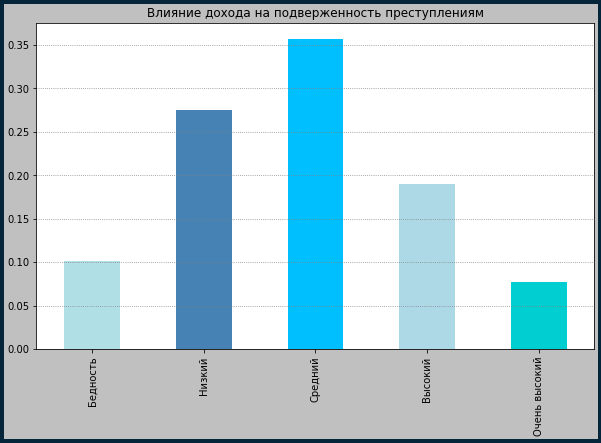

In [287]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_resp_income.plot.bar(color=colors)

plt.title('Влияние дохода на подверженность преступлениям')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод**:


> Распределение процентного отношения подверженности преступлениям среди разных уровней дохода близко к нормальному распределению.



Теперь попробуем определить зависимость между уровнем дохода и типом преступления. Для этого создадим выборки по каждому уровню дохода и найдем процентное соотношение видов преступлений среди полученных выборок

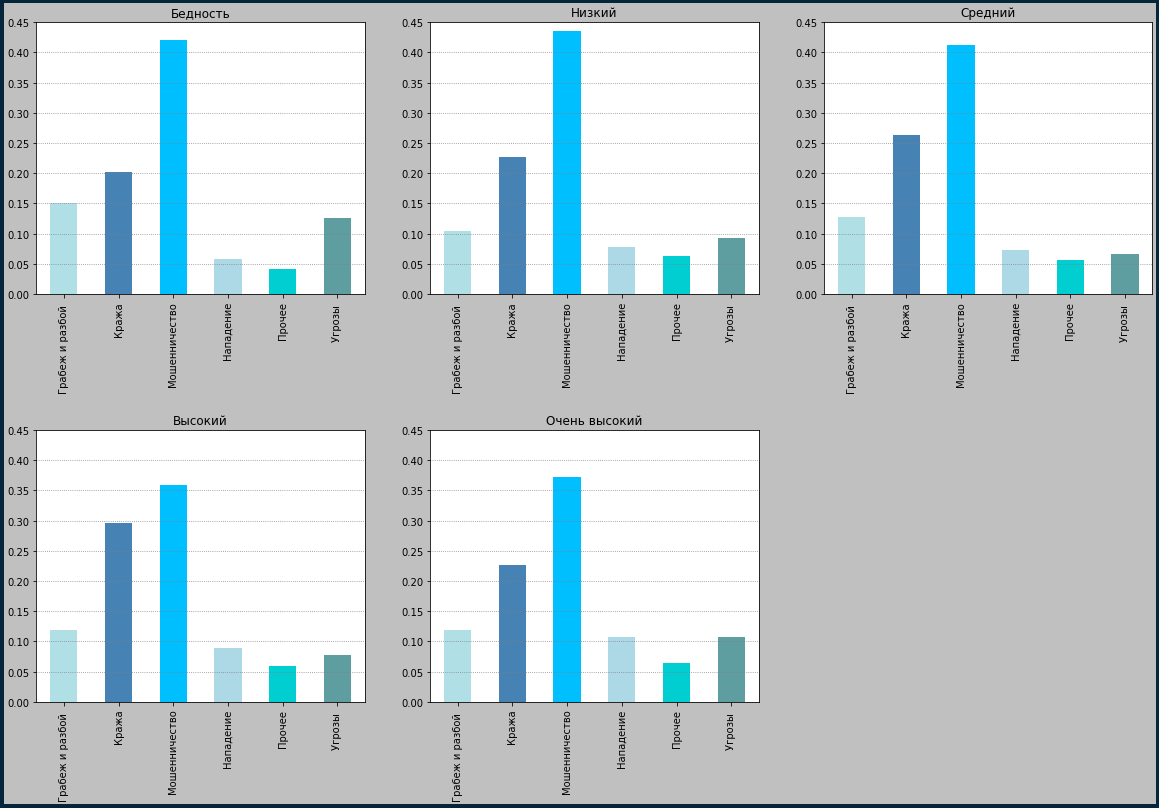

In [290]:
#Графики процента вида преступления для каждого уровня доходов

# Переменная, содержащая уровень благосостояния жертвы и тип преступления, которому она подверглась
crime_income = pd.concat([victims['crime_type'].drop(victims['crime_type']
                        [victims['crime_type'] == 8.0].index),
                        victims['resp_income']], axis=1).dropna()
s = []
for i in range(1, 6):
  s.append(crime_income[crime_income['resp_income'] == i]['crime_type']
           .apply(crime_type_rename).value_counts(1).sort_index())
  
# Красивые графики
plt.figure(figsize=(20, 20), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.subplot(3, 3, 1).set_title("Бедность")
s[0].plot.bar(color=colors)
plt.ylim(0, 0.45)
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.subplot(3, 3, 2).set_title("Низкий")
s[1].plot.bar(color=colors)
plt.ylim(0, 0.45)
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.subplot(3, 3, 3).set_title("Средний")
s[2].plot.bar(color=colors)
plt.ylim(0, 0.45)
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.subplot(3, 3, 4).set_title("Высокий")
s[3].plot.bar(color=colors)
plt.ylim(0, 0.45)
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.subplot(3, 3, 5).set_title("Очень высокий")
s[4].plot.bar(color=colors)
plt.ylim(0, 0.45)
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**

> Среди всех уровней дохода наиболее распространённым видом преступления является мошенничество

> Бедные больше других подвержены грабежам и разбоям

> Жертвами угроз и нападений чаще всего становятся лица с очень высоким уровнем дохода

> Высокий класс больше других подвержен кражам



## Анализ скорости реагирования правоохранителей

Определим скорость реагирования правоохранительных органов на преступления.

Создадим функцию для замены номера категории на её название

In [243]:
def reaction_time_group(x):
  d = {1.0: "Менее чем 30 минут",
       2.0: "Менее чем 1 час",
       3.0: "Менее чем 3 часа",
       4.0: "Менее чем 6 часов",
       5.0: "Менее чем 12 часов",
       6.0: "Не приехали"}
  return d[x]

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [244]:
police_react = victims['victim_police_reaction_time'] \
              .dropna().sort_values().drop(
              victims['victim_police_reaction_time']
              [victims['victim_police_reaction_time'] == 7.0].index) \
              .apply(reaction_time_group)

print("Выборка содержит", len(police_react), "строк")

Выборка содержит 422 строк


Посчитаем процентное содержание каждой категории в выборке

In [245]:
group_police_reaction = police_react.value_counts(1) \
                        .reindex(police_react.unique())

print("Полиция среагировала:")
for i in range(len(group_police_reaction)):
  print("{:<18} - {:.3f}%".format(group_police_reaction.index[i],
                                  group_police_reaction[i] * 100))


Полиция среагировала:
Менее чем 30 минут - 50.000%
Менее чем 1 час    - 25.592%
Менее чем 3 часа   - 10.427%
Менее чем 6 часов  - 1.659%
Менее чем 12 часов - 2.844%
Не приехали        - 9.479%


Построим по полученным значениям график.


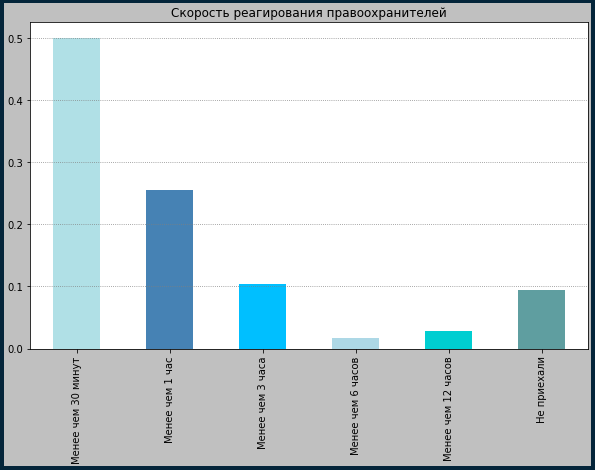

In [291]:
# Красивые графики
plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

group_police_reaction.plot.bar(color=colors)

plt.title('Скорость реагирования правоохранителей')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> В половине случаев правоохранители реагируют на вызов с должной скоростью

> Почти в каждом десятом случае полицейские не приезжают по вызову

## Анализ материального ущерба пострадавших

Проанализируем материальный ущерб пострадавшим, определим медианное и среднее значение материального ущерба.

Создадим выборку, содержащую материальный ущерб жертв преступлений и посчитаем её размер

In [247]:
damage_rub = victims['victim_damage_rub'] \
            [victims['victim_damage_rub'] != 0.0].dropna() 

print("Выборка содержит", len(damage_rub), "строк")

Выборка содержит 2007 строк


Теперь посчитаем средний и медианный материальные ущербы

In [248]:
damage_median = damage_rub.median()

damage_mean = damage_rub.mean()

print("Медиана материального ушерба - {} рублей"
        .format(int(damage_median)))

print("Среднее материального ушерба - {} рублей"
        .format(int(damage_mean)))

Медиана материального ушерба - 12000 рублей
Среднее материального ушерба - 3116267 рублей


Мы можем заметить что среднее значение значительно отличается от медианного, причина скорее всего скрывается в выбросах, попробуем их исключить.

In [249]:
print("До исключения выбросов выборка содержала", len(damage_rub), "строк")

damage_rub = damage_rub[(damage_rub * damage_median
                         / np.std(damage_rub)) < 3]

print("После исключения выбросов выборка содержит", len(damage_rub), "строк")

До исключения выбросов выборка содержала 2007 строк
После исключения выбросов выборка содержит 1452 строк


Повторим вычисления

In [250]:
damage_median_new = damage_rub.median()

damage_mean_new = damage_rub.mean()

print("Медиана материального ушерба после исключения выбросов - {} рублей"
        .format(int(damage_median_new)))

print("Отличие между медианой до исключения выбросов и после - {} рублей\n"
        .format(abs(int(damage_median_new) - int(damage_median))))

print("Среднее материального ушерба после исключения выбросов - {} рублей"
        .format(int(damage_mean_new)))

print("Отличие между средним до исключения выбросов и после - {} рублей"
        .format(abs(int(damage_mean_new) - int(damage_mean))))

Медиана материального ушерба после исключения выбросов - 7000 рублей
Отличие между медианой до исключения выбросов и после - 5000 рублей

Среднее материального ушерба после исключения выбросов - 9818 рублей
Отличие между средним до исключения выбросов и после - 3106449 рублей


Построим по полученным значениям график.

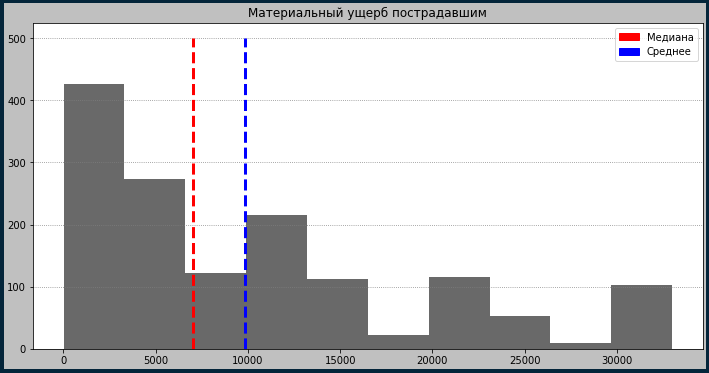

In [293]:
# Красивые графики
damage_index = [int(x) for x in damage_rub.index.tolist()]

plt.figure(figsize=(12, 6), linewidth=8, edgecolor="#04253a") \
.set_facecolor(pltclr)

plt.hist(damage_rub, color='dimgray')
plt.plot([damage_median_new, damage_median_new], [0, 500], 'r--', linewidth=3)
plt.plot([damage_mean_new, damage_mean_new], [0, 500], 'b--', linewidth=3)

med_patch = mpatches.Patch(color='red', label='Медиана')
mean_patch = mpatches.Patch(color='blue', label='Среднее')
plt.legend(handles=[med_patch, mean_patch])

plt.title('Материальный ущерб пострадавшим')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':') # boxplot

**Вывод:**
> Медианный материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 7 000 рублей.

> Средний материальный ущерб после исключения выбросов данных, полученный пострадавшими в результате преступления, составляет 9 818 рублей

## Анализ зависимости вида преступлений от времени суток

Определим процентное соотношение времени суток в момент совершения преступления.

Создадим функцию для замены номера категории на её название

In [252]:
def if_day(x):
  if x == 1.0:
    return 'День'
  else:
    return 'Ночь'

Создадим необходимую выборку из датафрейма и определим, достаточен ли ее размер для последующего анализа

In [253]:
victims_time = victims['crime_is_daytime'].dropna() \
.apply(if_day)

print("Выборка содержит", len(victims_time), "строк")

Выборка содержит 3001 строк


Посчитаем процентное содержание каждой категории в выборке

In [254]:
victims_time_count = victims_time.value_counts(1)

print("Время суток в момент совершения преступления:")
for i in range(len(victims_time_count)):
  print("{} - {:.3f}%".format(victims_time_count.index[i],
                                  victims_time_count[i] * 100))

Время суток в момент совершения преступления:
День - 65.178%
Ночь - 34.822%


Построим по полученным значениям график.

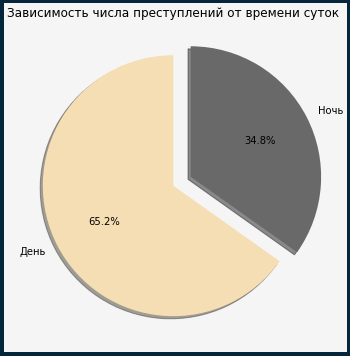

In [296]:
#Красивые графики
ax = plt.figure(figsize=(10, 6), linewidth=8, edgecolor="#04253a")
ax.set_facecolor(digclr)


plt.pie(victims_time_count, labels=victims_time_count.index, colors=('wheat','dimgray'),
        explode=(0, 0.15), shadow=True, startangle=90, autopct='%1.1f%%')

plt.title('Зависимость числа преступлений от времени суток')

plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

**Вывод:**
> Большая часть преступлений совершается в дневное время суток

Затем попробуем найти зависимость между определенным видом преступления и временем суток. Для этого создадим выборки по каждому виду преступлений и посчитаем процентное соотношение преступлений ночью и преступлений днем

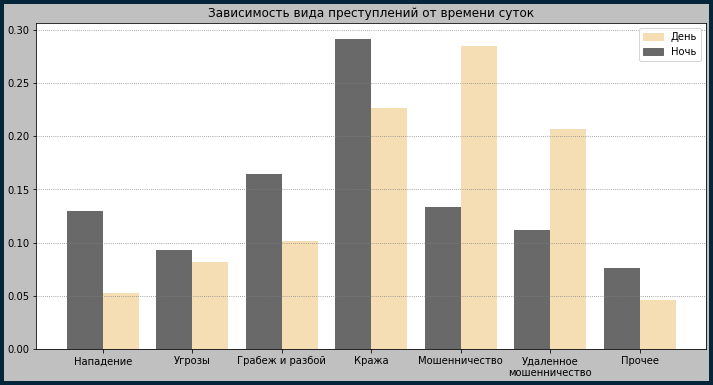

In [295]:
crimes = victims['crime_type'][victims['crime_type'] != 8.0]

daytime_crime = crimes[victims['crime_is_daytime'] == 1.0] \
.value_counts(1).sort_index().tolist()

nighttime_crime = crimes[victims['crime_is_daytime'] == 0.0] \
.value_counts(1).sort_index().tolist()

# Красивые графики
tick_names = ['Нападение',
              'Угрозы',
              'Грабеж и разбой',
              'Кража',
              'Мошенничество',
              'Удаленное\nмошенничество',
              'Прочее'] 

fig, ax = plt.subplots(linewidth=8, edgecolor="#04253a")

ax.bar(tick_names, daytime_crime, align='edge',
       width=0.4, color='wheat')
ax.bar(tick_names, nighttime_crime, align='edge',
       width=-0.4, color='dimgray')
plt.grid(which='major', color = 'gray', axis='y', linestyle=':')

plt.title('Зависимость вида преступлений от времени суток')

day_patch = mpatches.Patch(color='wheat', label='День')
night_patch = mpatches.Patch(color='dimgray', label='Ночь')
ax.legend(handles=[day_patch, night_patch])

ax.set_facecolor('white')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor(pltclr)

**Вывод:**
> Наиболее серьезные преступления, такие как нападения, угрозы, грабежи и разбои, кражи, совершаются в большинстве случаев в тёмное время суток

> Преступления, связанные с мошенничеством и удаленным мошенничеством, чаще всего совершаются днём

> Таким образом, несмотря на то, что большинство преступлений осуществляется днём, наиболее тяжкие из них осуществляются ночью. Процент дневных преступлений больше, поскольку значительная часть от них занимает мошенничество, осуществляемое в большинстве случаев в светлое время суток.